In [3]:
import os
import torch 
d = torch.device('cuda:3')
from RS.utils.dataset import Dataset as Mydataset
from RS.utils.evaluation import Evaluate
dataroot = os.path.join("data")

# Recommend

## METHOD1
Using all courses that a user have had taken.  



In [5]:
from RS.commoncourse import generate_rslist \
    as samecourse_method

In [10]:
method1_savepath = os.path.join("result", "commoncourse")
if not os.path.exists(method1_savepath):
    print(f"mkdir : {method1_savepath}")
    os.mkdir(method1_savepath)

### Steps:

1. __Generate__ $M_{category \times course}$

  - Input:
    - $M_{u_\text{train} \times category}$ : 
      - each entry $(u_j, cate_i)$ means the counts of category $cate_i$ being lended  by the trained-user $u_{j}$
    - $M_{u_{\text{train}} \times course}$ :
      - each entry $(u_j,course_k)$ means whether the trained-user $u_j$ had taken the course $course_k$. It is a binary matrix.

  - Output : 
    - $M_{category \times {course}}$: 
      - each entry of it means the mean counts of $category_i$ lended by the training students who had taken $course_j$.

  - Steps:
    1. $M_{norm, u_\text{train}\times course} := $ normalize $M_{u_\text{{train}} \times course}$ along it's column by $L_1$ norm.

    2. $M_{category \times {course}} \gets M_{u_\text{{train}} \times category}^T \times  M_{norm, u_\text{{train}}\times course}$

    3. return  $M_{category \times {course}}$

2. Generate recommend list: 

    $\textbf{for}$ each ${u_{\text{test}_\text{t}}}\in $ testing users:

  - Input (from step 1. directly):
    - $M_{ij}$: 
      - Mean counts of $\text{category}_i$ lended by the training students who had taken $\text{course}_j$. 

    - $Course_{u_{\text{test}_\text{t}}}$: 
      - $\{course_{i} \textbf{ }| \textbf{ } course_{i} \in$  course selection records of  ${u_{\text{test}_\text{t}}} \}$.
    - $topN$: 
      - top-N categories needed to be recommended.
  - Output : 
    - topN Recommend categories for a cold-started user ${u_{\text{test}_\text{t}}}$

  - Steps :
    1. __initialize__ : $CategoryCount_{{u_{\text{test}_\text{t}}}} := [0]_{1 \times |categories|}$

    2. For {$category_i$ $\in$ all categories}
      - $CategoryCount_{u_{\text{test}_\text{t}}}[category_i] \gets \frac{ \displaystyle\sum_{course_j\in Course_{u_{\text{test}_\text{t}}}} M[category_i][course_j]}{|Course_{u_{\text{test}_\text{t}}}|}$

    3. return category indices of $topN$ maximum values of $CategoryCount_{u_{\text{test}_\text{t}}}$

In [ ]:
datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    )
}


dataset = Mydataset(datafolder=datafolder)

In [11]:
rslist_saving_path = samecourse_method(
    dataset=dataset, resultroot=method1_savepath, d=d
)

build book x user .. OK ..
prediction ..


100%|██████████| 1254/1254 [00:00<00:00, 1419.83it/s]


OK .. save at result/commoncourse/recommendlist.json


### Evaluation

In [8]:
"""
rslist_saving_path=os.path.join(
    method1_savepath, 
    "recommendlist.json"
)
"""

Evaluate(
    result_root=method1_savepath, 
    recommendlist = rslist_saving_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=list(str(i) for i in range(1000))
)

result/commoncourse/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:34<00:00,  1.17s/it]


Precision_Recall_F1 : result/commoncourse/metrics/metrics.jpg
PR : result/commoncourse/metrics/PR.jpg
ROC : result/commoncourse/metrics/ROC.jpg


## METHOD 2

CBMF

- reference: 
  - __Improving Top-N Recommendation for Cold-Start Users via Cross-Domain Information__
  - Authors: 
    Nima Mirbakhsh, Charles X. Ling
    
  - ACM Transactions on Knowledge Discovery from DataVolume 9Issue 4June 2015

In [2]:
cbmf_savepath = os.path.join("result", "CBMF")
if not os.path.exists(cbmf_savepath):
    print(f"mkdir : {cbmf_savepath}")
    os.mkdir(cbmf_savepath)
    os.mkdir(os.path.join(cbmf_savepath, "metrics"))

mkdir : result/CBMF


#### Non Clustering 

##### Build Cross Domain user item matrix

In [4]:
datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    ),
    "testing_user_book":os.path.join(
        dataroot, "book", "user_cate3_test.csv"
    )
}

dataset = Mydataset(datafolder=datafolder)
dataset.getdata("testing_user_book").head()

build dataset
read training_user_course:data/course/train.csv
..OK
read training_user_book:data/book/user_cate3_train.csv
..OK
read testing_user_course:data/course/test.csv
..OK
read testing_user_book:data/book/user_cate3_test.csv
..OK


,uid,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,499110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,499110003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,499110005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,499110006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,499110008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
dataset.mask_dataset(dname="testing_user_book")
dataset.getdata("testing_user_book").head()

AttributeError: 'Dataset' object has no attribute 'mask_dataset'

combine

In [ ]:
user_book_all.uid = user_book_all.uid.astype('str')
user_course_all.uid = user_course_all.uid.astype('str')

In [ ]:
info = {
    'testing_range':user_course_train.shape[0],
    'testing_user': book_user_test.columns.tolist()
}
with open(os.path.join(dataroot,"crossdomain","info.json"), "w+", encoding='utf-8') as f:
    json.dump(info, f, indent=4, ensure_ascii=False)


In [10]:
crossdomain_df = pd.concat(
    (user_book_all, user_course_all.drop(columns=['uid'])), axis = 1
)
crossdomain_df.head()

,uid,0,1,2,3,4,5,6,7,8,...,7507019,7507020,7507021,7507022,7507023,7507024,7507025,7507026,7507027,7507028
0,400110002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,400110003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,400110005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,400110006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,400110007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
crossdomain_df.to_csv(
    os.path.join(dataroot, "crossdomain", "bin_count_crossdomain.csv"),
    index=False
)

In [12]:
crossdomain_df.shape

(21829, 8055)

In [13]:
crossdomain = torch.tensor(
    crossdomain_df.drop(columns=['uid']).values,
    dtype=torch.float
)
crossdomain.size()
torch.save(crossdomain, os.path.join(
    "data", "crossdomain", "bin_crossdomain.pt")
)

##### MF

100%|██████████| 5/5 [00:12<00:00,  2.48s/it, mse=0.003, improve=0.0000, early=2]  


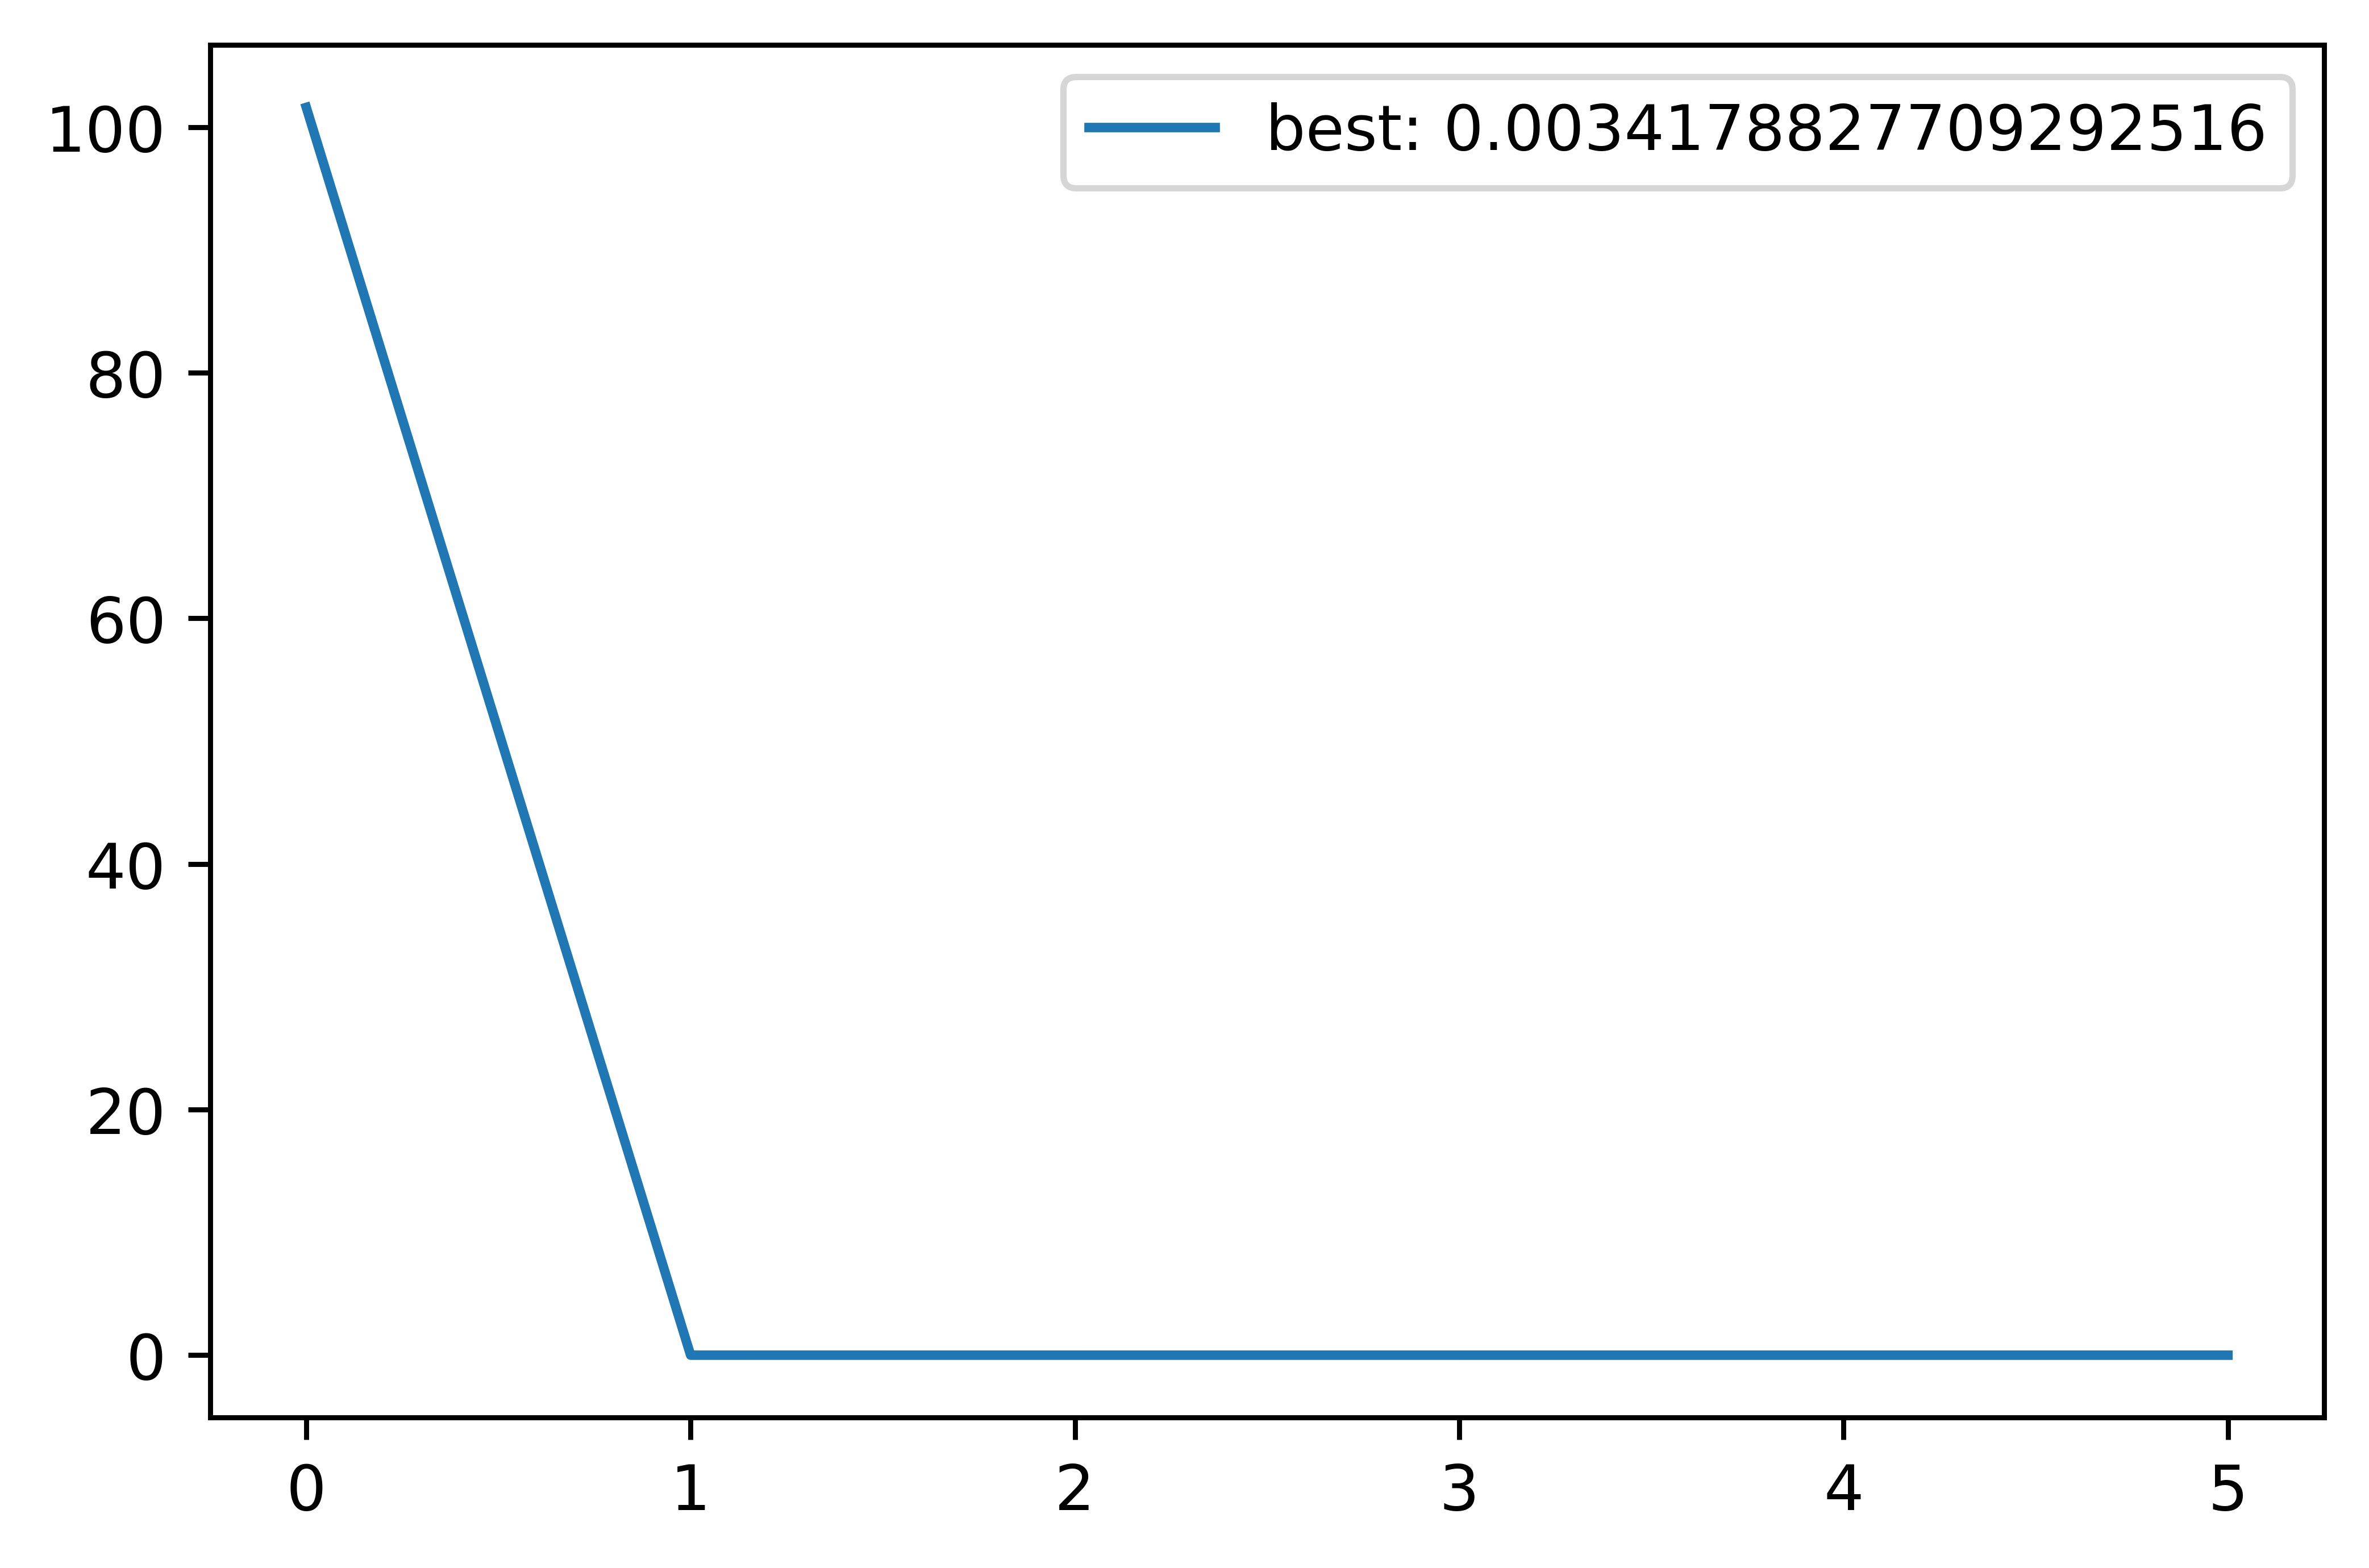

In [14]:
mf = ALS_MF(R=crossdomain)
h = mf.train(device=d,max_iteration=5)
plotLoss(h, savename=os.path.join(cbmf_savepath, "Navie", "mse.jpg"), showinline=True)

In [15]:
torch.save(
    mf.user_latency(),
    os.path.join(cbmf_savepath,"Navie","embedding", "user.pt")
)
torch.save(
    mf.item_latency(),
    os.path.join(cbmf_savepath,"Navie","embedding", "item.pt")
)
torch.save(
    mf.prediction(),
    os.path.join(cbmf_savepath, "Navie", "embedding", "predict.pt")
)

In [16]:
testing_range, testing_user = None, None
with open(os.path.join(dataroot,"crossdomain","info.json"), "r") as f:
    info = json.load(f)
    testing_range = info['testing_range']
    testing_user = info['testing_user']

In [17]:
testing_prediction = torch.load(
    os.path.join(cbmf_savepath, "Navie", "embedding", "predict.pt")
).numpy()[testing_range:,0:1000]
recommentlist = {}
print(testing_prediction.shape)
for ui in tqdm(range(testing_prediction.shape[0])):
    rank = np.argsort(-testing_prediction[ui]).tolist()
    recommentlist[testing_user[ui]] = list(str(c) for c in rank)
with open(os.path.join(cbmf_savepath,"Navie","NonC_recommendlist.json"), "w+", encoding='utf-8') as f:
    json.dump(recommentlist, f, indent = 4, ensure_ascii=False)
    

(1254, 1000)


100%|██████████| 1254/1254 [00:00<00:00, 3270.30it/s]


In [18]:
Evaluate(
    result_root=os.path.join(cbmf_savepath, "Navie"),
    recommendlist=os.path.join(cbmf_savepath, "Navie","NonC_recommendlist.json"),
    gth = os.path.join("result","testing_user_groundtruth.json"),
    item_list=list(str(c) for c in range(1000))
)

result/CBMF/Navie/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:56<00:00,  1.20s/it]


Precision_Recall_F1 : result/CBMF/Navie/metrics/metrics.jpg
PR : result/CBMF/Navie/metrics/PR.jpg
ROC : result/CBMF/Navie/metrics/ROC.jpg


#### Clustering regularization

In [8]:
cbmatrix = np.load(os.path.join(
    dataroot, "crossdomain", "cb.npy")
)
cbmatrix.shape

(91, 50)

100%|██████████| 50/50 [00:00<00:00, 146.51it/s, mse=0.002, improve=-0.0000, early=0]


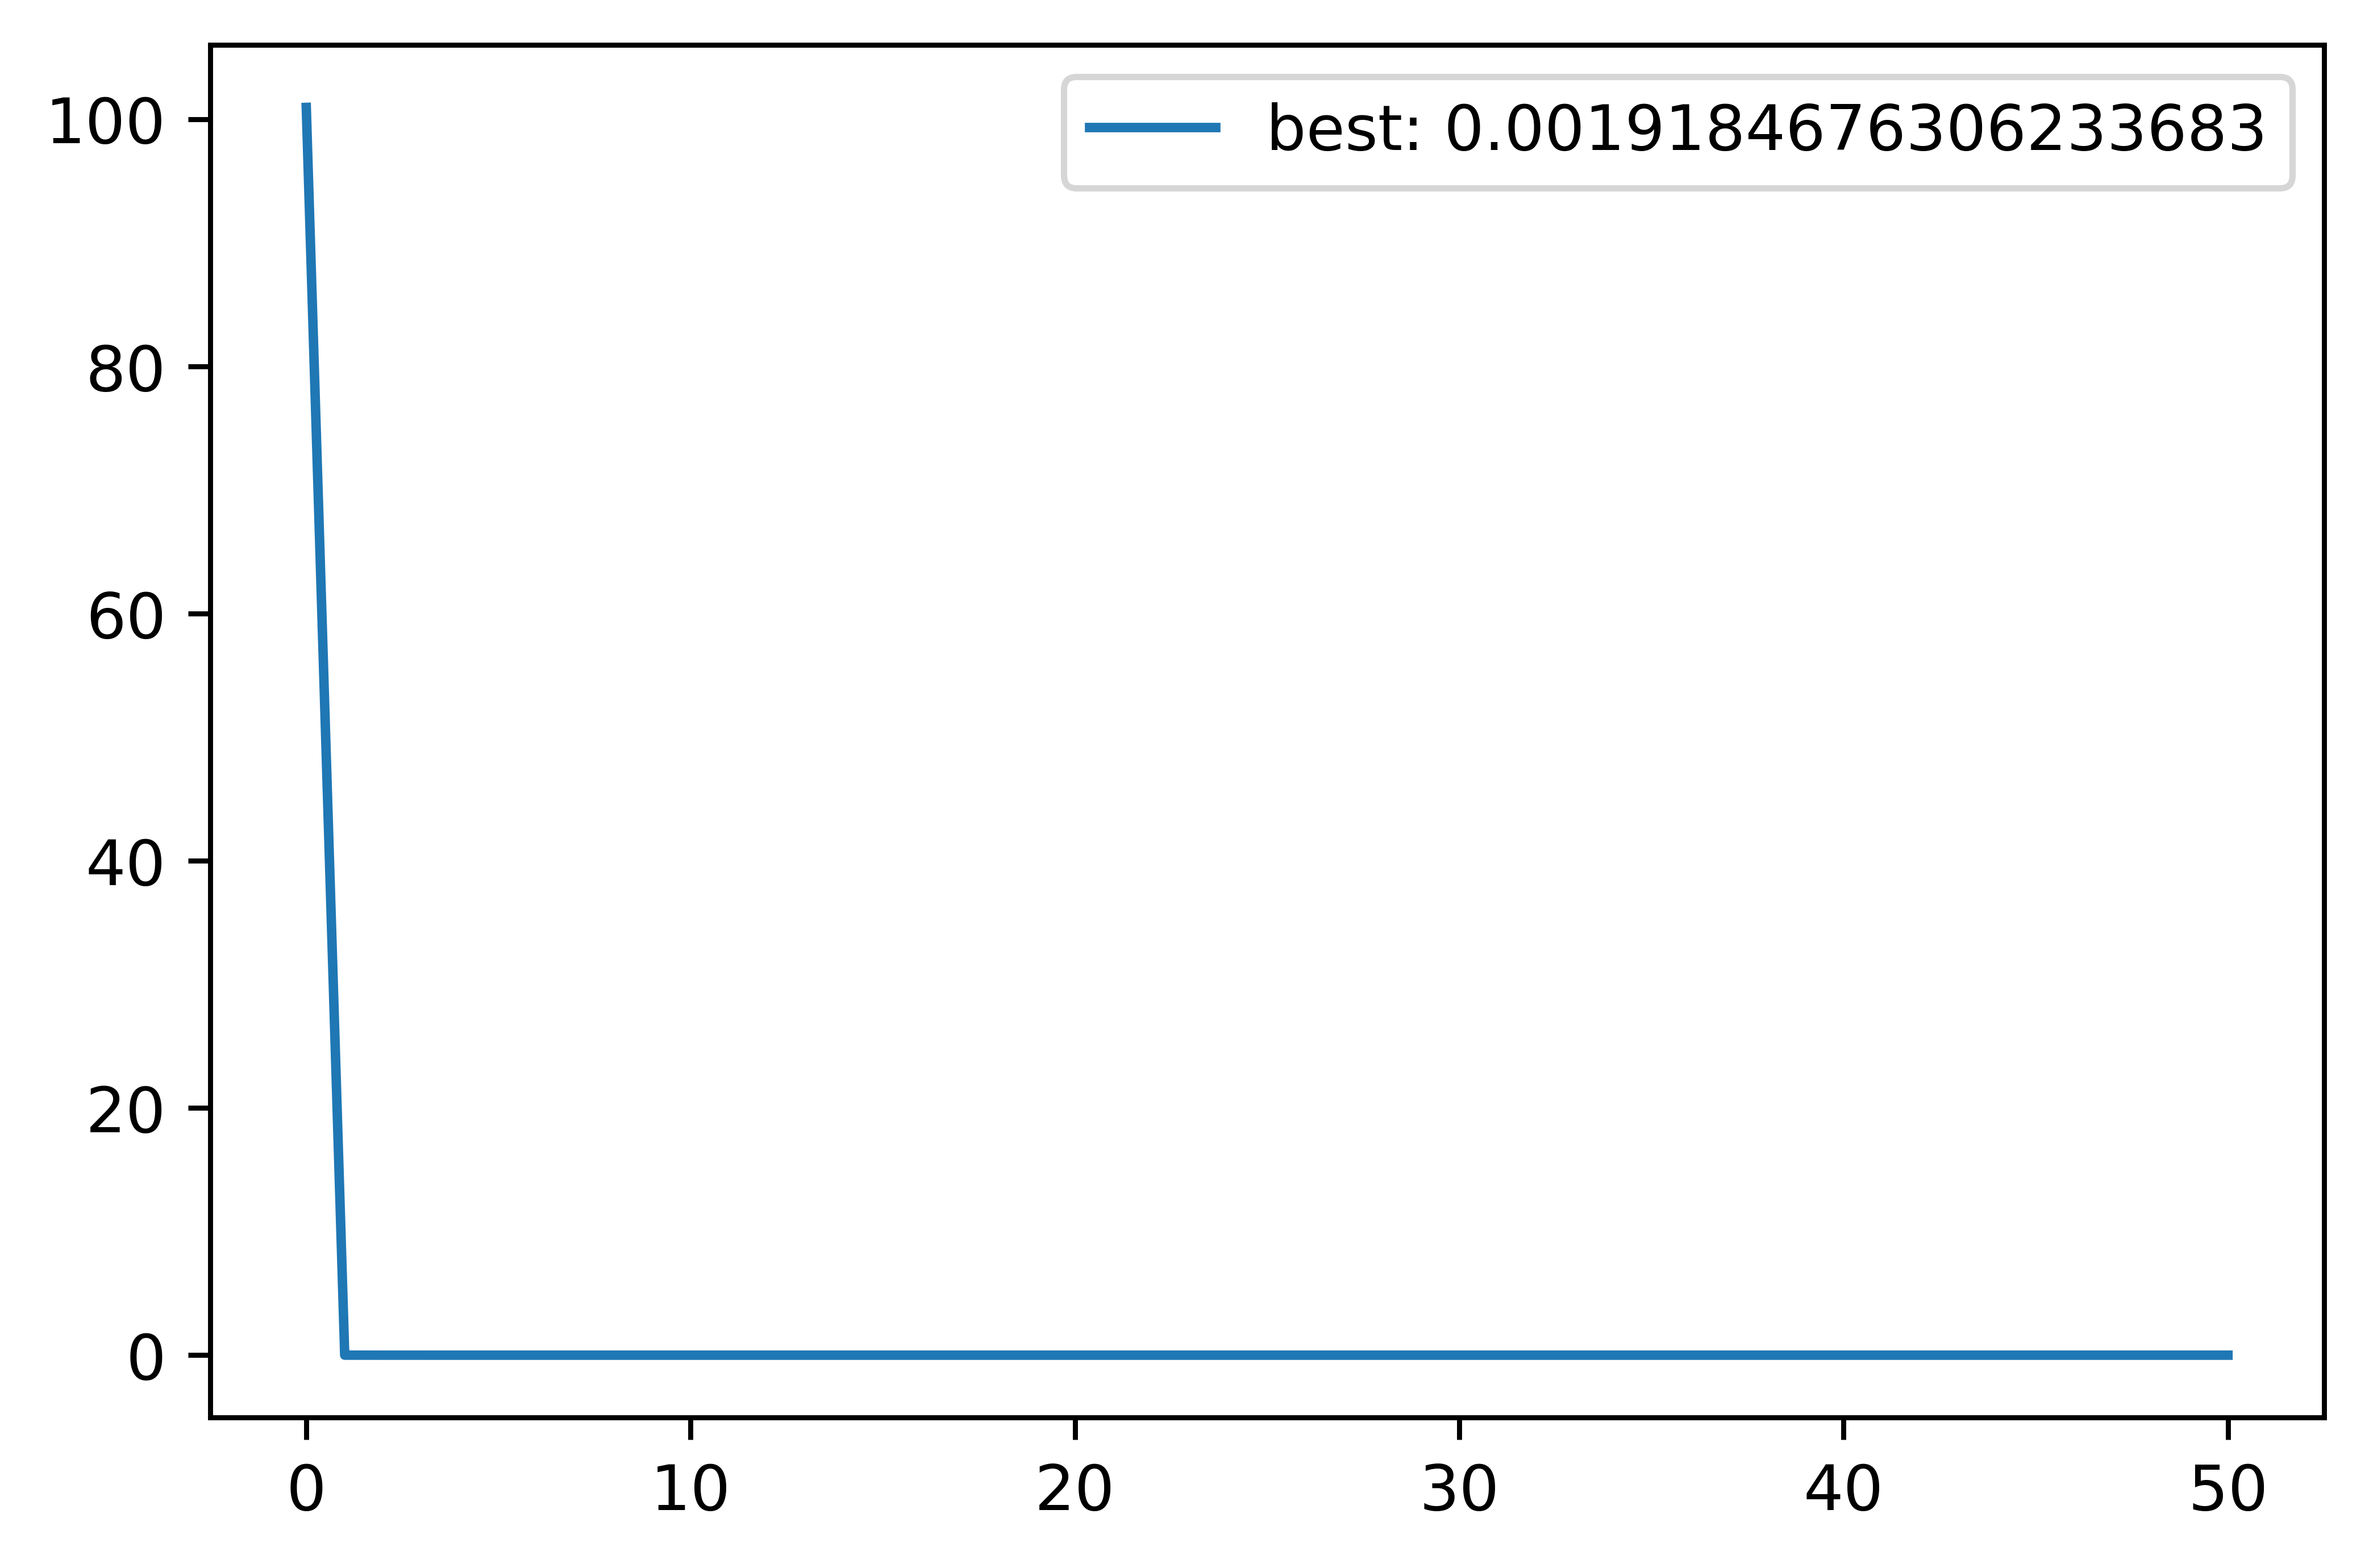

In [17]:
cbmf = ALS_MF(
    torch.tensor(cbmatrix,dtype=torch.double), l2_reg=0.5
)
h = cbmf.train(device=d)
plotLoss(h, savename=os.path.join(cbmf_savepath,"Navie", "clusteringMSE.jpg"), showinline=True)

In [19]:
torch.save(
    cbmf.user_latency(),
    os.path.join(cbmf_savepath,"Navie","cb_embedding", "user.pt")
)
torch.save(
    cbmf.item_latency(),
    os.path.join(cbmf_savepath,"Navie", "cb_embedding", "item.pt")
)
torch.save(
    cbmf.prediction(),
    os.path.join(cbmf_savepath,"Navie", "cb_embedding", "predict.pt")

)

In [20]:
testing_range, testing_user = None, None
with open(os.path.join(dataroot,"crossdomain","info.json"), "r") as f:
    info = json.load(f)
    testing_range = info['testing_range']
    testing_user = info['testing_user']

In [50]:
nonclustering= torch.load(
    os.path.join("result", "CBMF", "Navie", "embedding","predict.pt")
).numpy()
print(nonclustering.shape)
testpart = nonclustering[testing_range:,0:1000]
print(testpart.shape)

(21829, 8054)
(1254, 1000)


In [49]:
cluster_prediction = torch.load(
    os.path.join(cbmf_savepath,"Navie", "cb_embedding", "predict.pt")
).numpy()[:,-10:]
cluster_prediction.shape

(91, 10)

In [30]:
user_cluster = {
    'course':{},
    'book':cluster_prediction.shape[0]-1
}
with open(
    os.path.join(dataroot,"crossdomain",
    "usercourse","user_clusters.json"
),"r") as f:
    c = json.load(f)
    for k in c:
        c[k] = list(str(u) for u in c[k])
    user_cluster['course'] = c



In [57]:
alpha = 0.5
recommendlist = {}

In [58]:
for i, ui in enumerate(tqdm(testing_user)):
    course_cluster = None
    for cid, members in user_cluster['course'].items():
        if ui in members:
            course_cluster = int(cid)
            break
    cluster_suggetion = cluster_prediction[course_cluster,:].repeat(100) 
    basic = testpart[i]
    score = alpha*cluster_suggetion+(1-alpha)*basic
    rank = np.argsort(-score).tolist()
    recommendlist[ui]=list(str(cate) for cate in rank )

with open(os.path.join(cbmf_savepath, "Navie","recommendlist.json"), "w+", encoding='utf-8') as f:
    json.dump(recommentlist, f, indent = 4, ensure_ascii=False)
    

100%|██████████| 1254/1254 [00:01<00:00, 848.81it/s]


In [60]:
Evaluate(
    result_root=os.path.join(cbmf_savepath, "Navie", "Cluster"),
    recommendlist=os.path.join(cbmf_savepath, "Navie","recommendlist.json"),
    gth = os.path.join("result","testing_user_groundtruth.json"),
    item_list=list(str(c) for c in range(1000))
)

result/CBMF/Navie/Cluster/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [26:56<00:00,  1.62s/it]


Precision_Recall_F1 : result/CBMF/Navie/Cluster/metrics/metrics.jpg
PR : result/CBMF/Navie/Cluster/metrics/PR.jpg
ROC : result/CBMF/Navie/Cluster/metrics/ROC.jpg
